# Iowa Prison Recidivism Analysis

Author: Robert Harrow

## Overview

Stakeholder: Iowa Department of Corrections
Business Questions:
1. What features can help predict recidivism?
2. What can the DoC do to reduce recidivism?

## Data Understanding & Preperation

### Importing Dataset

Dataset located at: https://mydata.iowa.gov/Correctional-System/3-Year-Recidivism-for-Offenders-Released-from-Pris/mw8r-vqy4

**Load Dependencies**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score

### Data Dictionary

| Column Name                | Description                                                                                                                                                                                                          |
|:---------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Fiscal Year Released       | Fiscal year (year ending June 30) for which the offender was released from prison.                                                                                                                                   |
| Recidivism Reporting Year  | Fiscal year (year ending June 30) that marks the end of the 3-year tracking period. For example, offenders exited prison in FY 2012 are found in recidivism reporting year FY 2015.                                  |
| Main Supervising District  | The Judicial District supervising the offender for the longest time during the tracking period.                                                                                                                      |
| Release Type               | Reasoning for Offender's release from prison.                                                                                                                                                                        |
| Race - Ethnicity           | Offender's Race and Ethnicity                                                                                                                                                                                        |
| Age At Release             | Offender's age group at release from prison.                                                                                                                                                                         |
| Sex                        | Gender of our offender                                                                                                                                                                                               |
| Offense Classification     | Maximum penalties: A Felony = Life; B Felony = 25 or 50 years; C Felony = 10 years; D Felony = 5 years; Aggravated Misdemeanor = 2 years; Serious Misdemeanor = 1 year; Simple Misdemeanor = 30 days                 |
| Offense Type               | General category for the most serious offense for which the offender was placed in prison.                                                                                                                           |
| Offense Subtype            | Further classification of the most serious offense for which the offender was placed in prison.                                                                                                                      |
| Return to Prison           | No = Did not return to prison within the three year tracking period; Yes = Admitted to prison for any reason within the three year tracking period                                                                   |
| Days to Return             | Number of days it took before the offender returned to prison.                                                                                                                                                       |
| Recidivism Type            | Indicates the reason for return to prison.                                                                                                                                                                           |
| New Offense Classification | New conviction maximum penalties: A Felony = Life; B Felony = 25 or 50 years; C Felony = 10 years; D Felony = 5 years; Aggravated Misdemeanor = 2 years; Serious Misdemeanor = 1 year; Simple Misdemeanor = 30 days  |
| New Offense Type           | General category for the new conviction while the offender is out of prison.                                                                                                                                         |
| New Offense Sub Type       | Further classification of the new conviction.                                                                                                                                                                        |
| Target Population          | The Department of Corrections has undertaken specific strategies to reduce recidivism rates for prisoners who are on parole.                                                                                         |


In [43]:
prisoner_df = pd.read_csv('data/recidivism.csv')

In [3]:
# Preview first 5 rows
prisoner_df.head()

,Fiscal Year Released,Recidivism Reporting Year,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Offense Subtype,Return to Prison,Days to Return,Recidivism Type,New Offense Classification,New Offense Type,New Offense Sub Type,Target Population
0,2010,2013,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,433.0,New,C Felony,Drug,Trafficking,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,453.0,Tech,NaN,NaN,NaN,No
2,2010,2013,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,832.0,Tech,NaN,NaN,NaN,Yes
3,2010,2013,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,NaN,No Recidivism,NaN,NaN,NaN,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,116.0,Tech,NaN,NaN,NaN,No


In [4]:
# Get overview of the data
prisoner_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020 entries, 0 to 26019
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Fiscal Year Released        26020 non-null  int64  
 1   Recidivism Reporting Year   26020 non-null  int64  
 2   Main Supervising District   16439 non-null  object 
 3   Release Type                24258 non-null  object 
 4   Race - Ethnicity            25990 non-null  object 
 5   Age At Release              26017 non-null  object 
 6   Sex                         26017 non-null  object 
 7   Offense Classification      26020 non-null  object 
 8   Offense Type                26020 non-null  object 
 9   Offense Subtype             26020 non-null  object 
 10  Return to Prison            26020 non-null  object 
 11  Days to Return              8681 non-null   float64
 12  Recidivism Type             26020 non-null  object 
 13  New Offense Classification  671

In [5]:
# Explore distribution of target

prisoner_df['Return to Prison'].value_counts()

No     17339
Yes     8681
Name: Return to Prison, dtype: int64

In [6]:
prisoner_df['Recidivism Type'].value_counts()

No Recidivism    17339
New               5516
Tech              3165
Name: Recidivism Type, dtype: int64

In [7]:
# Exploring proportion of missing data
prisoner_df.isna().mean()

Fiscal Year Released          0.000000
Recidivism Reporting Year     0.000000
Main Supervising District     0.368217
Release Type                  0.067717
Race - Ethnicity              0.001153
Age At Release                0.000115
Sex                           0.000115
Offense Classification        0.000000
Offense Type                  0.000000
Offense Subtype               0.000000
Return to Prison              0.000000
Days to Return                0.666372
Recidivism Type               0.000000
New Offense Classification    0.741814
New Offense Type              0.741814
New Offense Sub Type          0.742544
Target Population             0.000000
dtype: float64

### Basic Data Cleaning

Data is missing for the following columns:
* **Main Supervising District.** Based on an email I received from the Iowa Department of Corrections <em>"When a Main Supervising District is blank, this means they discharged straight from prison and were not supervised by Community Based Corrections."</em>
* **Release Type/Race - Ethnicity/Age At Release/Sex.** Just 0.01% - 6% of data is missing here. I will likely just drop these records.
* **Days to Return/New Offense Classification/New Offense Type/New Offense Sub Type.** It makes sense for this data to be missing since we have records of people who never returned to prison. Also, we don't need these columns for modeling.

In [44]:
# Replacing Main Supervising District NaN with 'None'
prisoner_df['Main Supervising District'] = prisoner_df['Main Supervising District'].fillna('None')

In [45]:
# Dealing with records with small amounts of missing values
prisoner_df.dropna(subset=['Release Type', 'Race - Ethnicity','Age At Release ','Sex'], inplace=True)

In [ ]:
# Since we are dealing with data for just a few years, we'll treat it as a string/category rather than a continuous int

prisoner_df_relevant["Fiscal Year Released"]=prisoner_df_relevant["Fiscal Year Released"].values.astype(str)
prisoner_df_relevant["Recidivism Reporting Year"]=prisoner_df_relevant["Recidivism Reporting Year"].values.astype(str)

In [46]:
# Dropping columns not needed for modeling
cols_to_drop = ['Recidivism Reporting Year',
                'Days to Return',
                'Recidivism Type',
                'New Offense Classification',
                'New Offense Type',
                'New Offense Sub Type',
                'Offense Subtype' # dropping this for now since it has a lot of categories]

In [47]:
prisoner_df_relevant = prisoner_df.drop(cols_to_drop, axis=1)

In [49]:
prisoner_df_relevant["Return to Prison"].replace({"Yes": 1, "No": 0}, inplace=True)

In [31]:
for col in prisoner_df_relevant.columns:
    print(prisoner_df_relevant[col].value_counts())

2012    4707
2013    4687
2015    4374
2011    3917
2010    3716
2014    2824
Name: Fiscal Year Released, dtype: int64
2015    4707
2016    4687
2018    4374
2014    3917
2013    3716
2017    2824
Name: Recidivism Reporting Year, dtype: int64
None                  7787
5JD                   4982
1JD                   2787
2JD                   1988
8JD                   1556
7JD                   1514
3JD                   1188
6JD                   1098
4JD                    666
ISC                    350
Interstate Compact     309
Name: Main Supervising District, dtype: int64
Parole                                 9810
Parole Granted                         5577
Discharged – End of Sentence           5007
Discharged - Expiration of Sentence    2335
Released to Special Sentence            401
Special Sentence                        347
Paroled w/Immediate Discharge           334
Paroled to Detainer - Out of State      137
Paroled to Detainer - INS               134
Paroled to Detaine

In [87]:
# Dropping Race - Ethnicity group for which we don't have too much data for
prisoner_df_relevant = prisoner_df_relevant.groupby('Race - Ethnicity').filter(lambda x: len(x) > 100)

### Split data for cleaning & training

In [88]:
X = prisoner_df_relevant.drop(['Return to Prison'], axis=1)
y = prisoner_df_relevant['Return to Prison']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [89]:
def release_type_transformer(df):
    '''
    Create 3 bins to reduce release type to the three major types of prison releases
    '''
    df.loc[df['Release Type'].str.contains('parole', case=False), 'Release Type'] = 'parole'
    df.loc[df['Release Type'].str.contains('discharged', case=False), 'Release Type'] = 'discharged'
    df.loc[df['Release Type'].str.contains('special', case=False), 'Release Type'] = 'special sentence'
    return df

def offense_classification_transformer(df):
    '''
    Create 3 bins to reduce release type to the three major types of prison releases
    '''
    df.loc[df['Offense Classification'].str.contains('felony', case=False), 'Offense Classification'] = 'felony'
    df.loc[df['Offense Classification'].str.contains('misdemeanor', case=False), 'Offense Classification'] = 'misdemeanor'
    df.loc[df['Offense Classification'].str.contains('Special Sentence', case=False), 'Offense Classification'] = 'other'
    df.loc[df['Offense Classification'].str.contains('Sexual Predator', case=False), 'Offense Classification'] = 'other'
    return df

In [90]:
cleaning_pipeline = Pipeline(steps=[
    ('release', FunctionTransformer(release_type_transformer)),
    ('classification', FunctionTransformer(offense_classification_transformer))
])

In [91]:
X_train_clean = cleaning_pipeline.fit_transform(X_train)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-89-60aca9cc8ce1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['Release Type'].str.contains('parole', case=False), 'Release Type'] = 'parole'
<ipython-input-89-60aca9cc8ce1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['

In [92]:
X_train_clean

,Fiscal Year Released,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Offense Subtype,Target Population
17734,2014,5JD,parole,White - Non-Hispanic,25-34,Male,felony,Public Order,OWI,No
15318,2013,5JD,parole,White - Non-Hispanic,25-34,Male,felony,Drug,Trafficking,Yes
487,2010,None,discharged,White - Non-Hispanic,Under 25,Male,felony,Violent,Sex,No
10967,2012,5JD,parole,White - Non-Hispanic,35-44,Male,felony,Drug,Other Drug,Yes
2945,2010,None,discharged,White - Non-Hispanic,Under 25,Male,felony,Property,Burglary,No
...,...,...,...,...,...,...,...,...,...,...
10333,2012,None,discharged,White - Non-Hispanic,45-54,Male,felony,Property,Theft,No
10647,2012,1JD,parole,Black - Non-Hispanic,35-44,Male,felony,Drug,Trafficking,Yes
3538,2010,6JD,parole,White - Non-Hispanic,25-34,Female,felony,Property,Theft,Yes
14715,2013,6JD,parole,Asian or Pacific Islander - Non-Hispanic,Under 25,Male,felony,Property,Theft,Yes


### Model Iterations

In [18]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    # we pass in pipe to cross validate along with a feature list.
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Macro Precision:', results['train_precision_macro'].mean())
    print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
    print('##############')
    print('Training Macro Recall:', results['train_recall_macro'].mean())
    print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
    print('##############')
    print('Training Macro F1:', results['train_f1_macro'].mean())
    print('Cross_Val Macro F1:', results['test_f1_macro'].mean())

### Dummy classifier

In [93]:
dummy_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")),
    ('dc', DummyClassifier(strategy='most_frequent'))])

In [94]:
dummy_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('dc', DummyClassifier(strategy='most_frequent'))])

In [95]:
print_cv_scores(dummy_pipe, X_train_clean, y_train)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\learn-env\lib\s

[0.65587687 0.65587687 0.65590062 0.65583161 0.65583161]
Training Accuracy 0.6558635162697615
##############
[0.6558101  0.6558101  0.65571507 0.65599117 0.65599117]
Cross_Val Accuracy 0.6558635217998757
##############
Training Macro Precision: 0.32793175813488074
Cross_Val Macro Precision: 0.32793176089993786
##############
Training Macro Recall: 0.5
Cross_Val Macro Recall: 0.5
##############
Training Macro F1: 0.39608549228276707
Cross_Val Macro F1: 0.39608549180816954


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\learn-env\lib\s

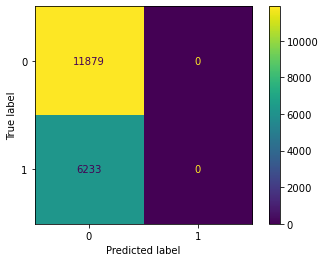

In [97]:
plot_confusion_matrix(dummy_pipe, X_train_clean, y_train)

### Logistic Regression classifier

In [98]:
lr_param_grid = {
    'lr__penalty': ['none', 'l1'],
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__class_weight': [None, 'balanced'],
}

lr_pipe = imbpipe(steps=[
    ("ohe", OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")),
    ('sm', SMOTE(random_state=42)),
    ('lr', LogisticRegression())
])

gridsearch = GridSearchCV(estimator=lr_pipe, 
                          param_grid=lr_param_grid, 
                          scoring='recall', 
                          cv=5)

# Fit the training data
gridsearch.fit(X_train_clean, y_train)

# Print the recall on test set and best params
print(gridsearch.score(X_test, y_test))

print(gridsearch.best_params_)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_l

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "

0.78055822906641
{'lr__C': 0.01, 'lr__class_weight': None, 'lr__penalty': 'none'}


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_l

[0.61488025 0.61287874 0.61338854 0.61435473 0.6131815 ]
Training Accuracy 0.613736753057137
##############
[0.61054375 0.60861165 0.60325787 0.61181668 0.61651022]
Cross_Val Accuracy 0.6101480311763622
##############
Training Macro Precision: 0.6123965855655907
Cross_Val Macro Precision: 0.6083860699486212
##############
Training Macro Recall: 0.62448210793063
Cross_Val Macro Recall: 0.6199812597533979
##############
Training Macro F1: 0.603560496055396
Cross_Val Macro F1: 0.599637539330225


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


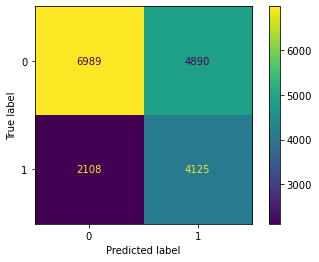

In [99]:
# Logistic Regression with best params

lr_pipe2 = imbpipe(steps=[
    ("ohe", OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")),
    ('sm', SMOTE(random_state=42)),
    ('lr', LogisticRegression(C= 0.01, class_weight= None, penalty= 'none'))
])

lr_pipe2.fit(X_train_clean, y_train)

print_cv_scores(lr_pipe2, X_train_clean, y_train)
plot_confusion_matrix(lr_pipe2, X_train_clean, y_train)

### Decision Tree classifier

In [100]:
dt1_pipe = imbpipe(steps=[
    ("ohe", OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")),
    ('sm', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier())
])

dt_param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 2, 3, 4, 5, 6],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

dt_gridsearch = GridSearchCV(estimator=dt1_pipe, 
                          param_grid=dt_param_grid, 
                          scoring='recall', 
                          cv=5)

# Fit the training data
dt_gridsearch.fit(X_train_clean, y_train)

# Print the recall on test set and best params
print(dt_gridsearch.score(X_test, y_test))
print(dt_gridsearch.best_params_)

0.7959576515880654
{'dt__criterion': 'gini', 'dt__max_depth': 2, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}


[0.52598523 0.52543309 0.52456867 0.52491373 0.53657695]
Training Accuracy 0.5274955337241869
##############
[0.52194314 0.52415126 0.52760906 0.5262286  0.53451132]
Cross_Val Accuracy 0.526888675074715
##############
Training Macro Precision: 0.5933766457244846
Cross_Val Macro Precision: 0.5928136390491323
##############
Training Macro Recall: 0.5908007609031292
Cross_Val Macro Recall: 0.5901748794488777
##############
Training Macro F1: 0.5273155790060262
Cross_Val Macro F1: 0.5266655371667108


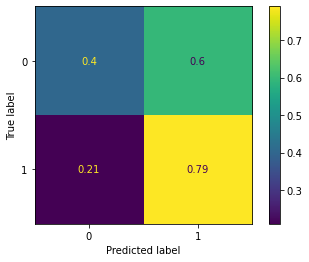

In [103]:
# Optimized Decision Tree
dt2_pipe = imbpipe(steps=[
    ("ohe", OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")),
    ('sm', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(criterion='gini', max_depth = 2, min_samples_leaf = 1, min_samples_split= 2))
])

dt2_pipe.fit(X_train_clean, y_train)


print_cv_scores(dt2_pipe, X_train_clean, y_train)
plot_confusion_matrix(dt2_pipe, X_train_clean, y_train, normalize='true')

### Random Forest classifier

In [104]:
# Searching for the best RF hyperparameters
rf_grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [2, 5, 10], 
         'RF__min_samples_leaf': [1, 3, 5]}]

rf1_pipe = imbpipe(steps=[
    ("ohe", OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")),
    ('sm', SMOTE(random_state=42)),
    ('RF', RandomForestClassifier(random_state=123))
])

rf_gridsearch = GridSearchCV(estimator=rf1_pipe, 
                          param_grid=rf_grid, 
                          scoring='recall', 
                          cv=5)

# Fit the training data
rf_gridsearch.fit(X_train_clean, y_train)

# Print the recall on test set and best params
print(rf_gridsearch.score(X_test, y_test))
print(rf_gridsearch.best_params_)

0.6958614051973051
{'RF__max_depth': 4, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 5}


[0.59341569 0.59721168 0.60034507 0.59026915 0.59951691]
Training Accuracy 0.5961516994806416
##############
[0.57797405 0.59122274 0.59221425 0.58696853 0.5993926 ]
Cross_Val Accuracy 0.5895544341911523
##############
Training Macro Precision: 0.6073166084510677
Cross_Val Macro Precision: 0.6006413475497228
##############
Training Macro Recall: 0.6182914723981753
Cross_Val Macro Recall: 0.6109164519431165
##############
Training Macro F1: 0.590062914831788
Cross_Val Macro F1: 0.5833275488524776


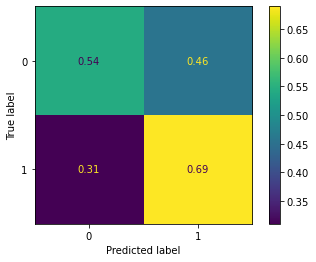

In [105]:
# Optimized RT Classifier

rf2_pipe = imbpipe(steps=[
    ("ohe", OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")),
    ('sm', SMOTE(random_state=42)),
    ('dt',  RandomForestClassifier(max_depth = 4, min_samples_leaf = 1, min_samples_split = 5, random_state=123))
])

rf2_pipe.fit(X_train_clean, y_train)


print_cv_scores(rf2_pipe, X_train_clean, y_train)
plot_confusion_matrix(rf2_pipe, X_train_clean, y_train, normalize='true')